## Generate synthetic Anomalies

trying to replicate the synthethic anomalies from the LOE paper

https://arxiv.org/abs/2202.08088
"""
Since the MVTEC training set contains
no anomalies, we contaminate it with artificial anomalies
that we create by adding zero-mean Gaussian noise to the
features of test set anomalies. We use a large variance for
the additive noise (equal to the empirical variance of the
anomalous features) to reduce information leakage from the
test set into the training set.
"""

In [1]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import matplotlib.image as mpimg
import pandas as pd
import os
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import seaborn as sns
import numpy as np
import torch.nn.functional as F
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import sys
sys.path.append('..')
from utils.helpers import *
# PATHs
PROJECT_DATA_PATH='//home/bule/projects/MVTec_Visualizer/data/mvtec_anomaly_detection'
LOG_DIR= '/home/bule/projects/MVTec_Visualizer/tensorboard_logs'

In [2]:
FILENAME = 'MVTEC_CLIP_embeddings_df'#'MVTEC_WIDERESNET50_3thBlock_embeddings_df'# MVTEC_CLIP_embeddings_df
df = pd.read_pickle(os.path.join(PROJECT_DATA_PATH,FILENAME+'.pkl'))
image_paths=[pts[1:]for pts in df.index]
df = df.set_index(pd.Index(image_paths))

In [3]:
anomaly_categories = {
    'bottle': ['broken_large', 'broken_small', 'contamination'],
    'cable': ['bent_wire', 'cable_swap', 'combined', 'cut_inner_insulation', 'cut_outer_insulation', 'missing_cable', 'missing_wire', 'poke_insulation'],
    'capsule': ['crack', 'faulty_imprint', 'poke', 'scratch','squeeze'],
    'carpet': ['color', 'cut', 'hole', 'metal_contamination', 'thread'],
    'grid': ['bent', 'broken', 'glue', 'metal_contamination', 'thread'],
    'hazelnut': ['crack', 'cut', 'hole', 'print'],
    'leather': ['color', 'cut', 'fold', 'glue', 'poke'],
    'metal_nut': ['bent', 'color', 'flip', 'scratch'],
    'pill': ['color', 'combined','contamination', 'crack', 'faulty_imprint', 'pill_type','scratch'],
    'screw': ['manipulated_front', 'scratch_head', 'scratch_neck','thread_side', 'thread_top'],
    'tile': ['crack', 'glue_strip', 'gray_stroke', 'oil','rough'],
    'toothbrush': ['defective'],
    'transistor': ['bent_lead', 'cut_lead', 'damaged_case', 'misplaced'],
    'wood': ['color', 'combined', 'hole', 'liquid', 'scratch'],
    'zipper': ['broken_teeth', 'combined','fabric_border', 'fabric_interior','split_teeth','rough', 'squeezed_teeth']}

# change class here
category='carpet'

combined_samples,labels,class_list= create_synset_for_class(category,df)

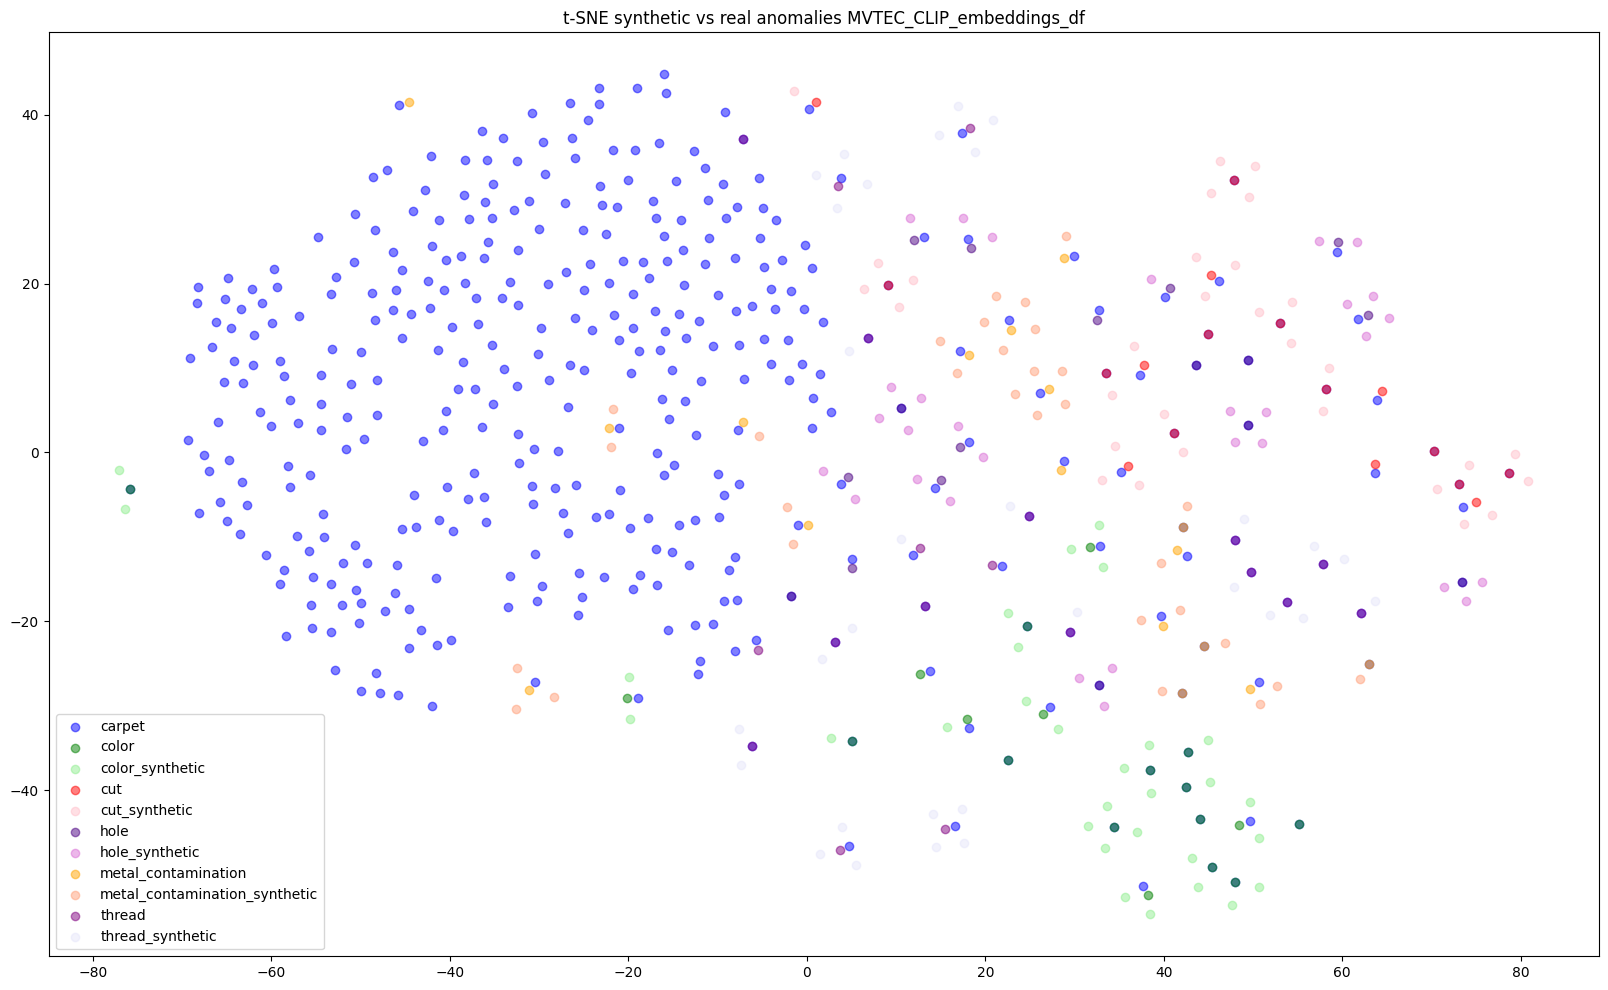

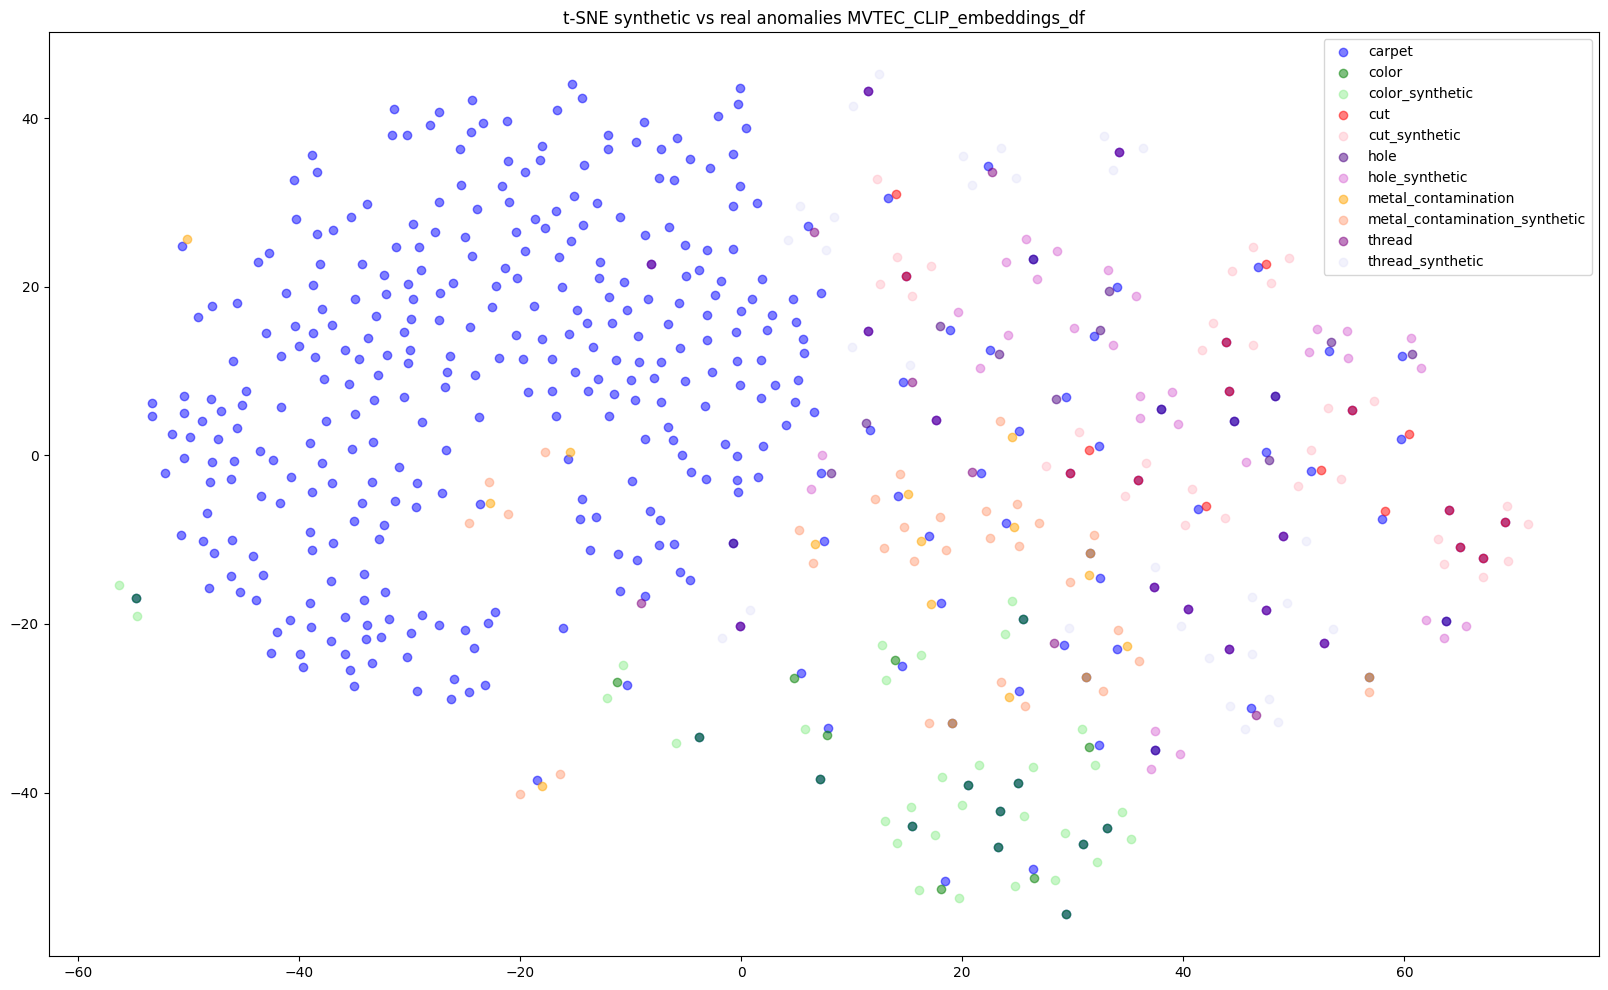

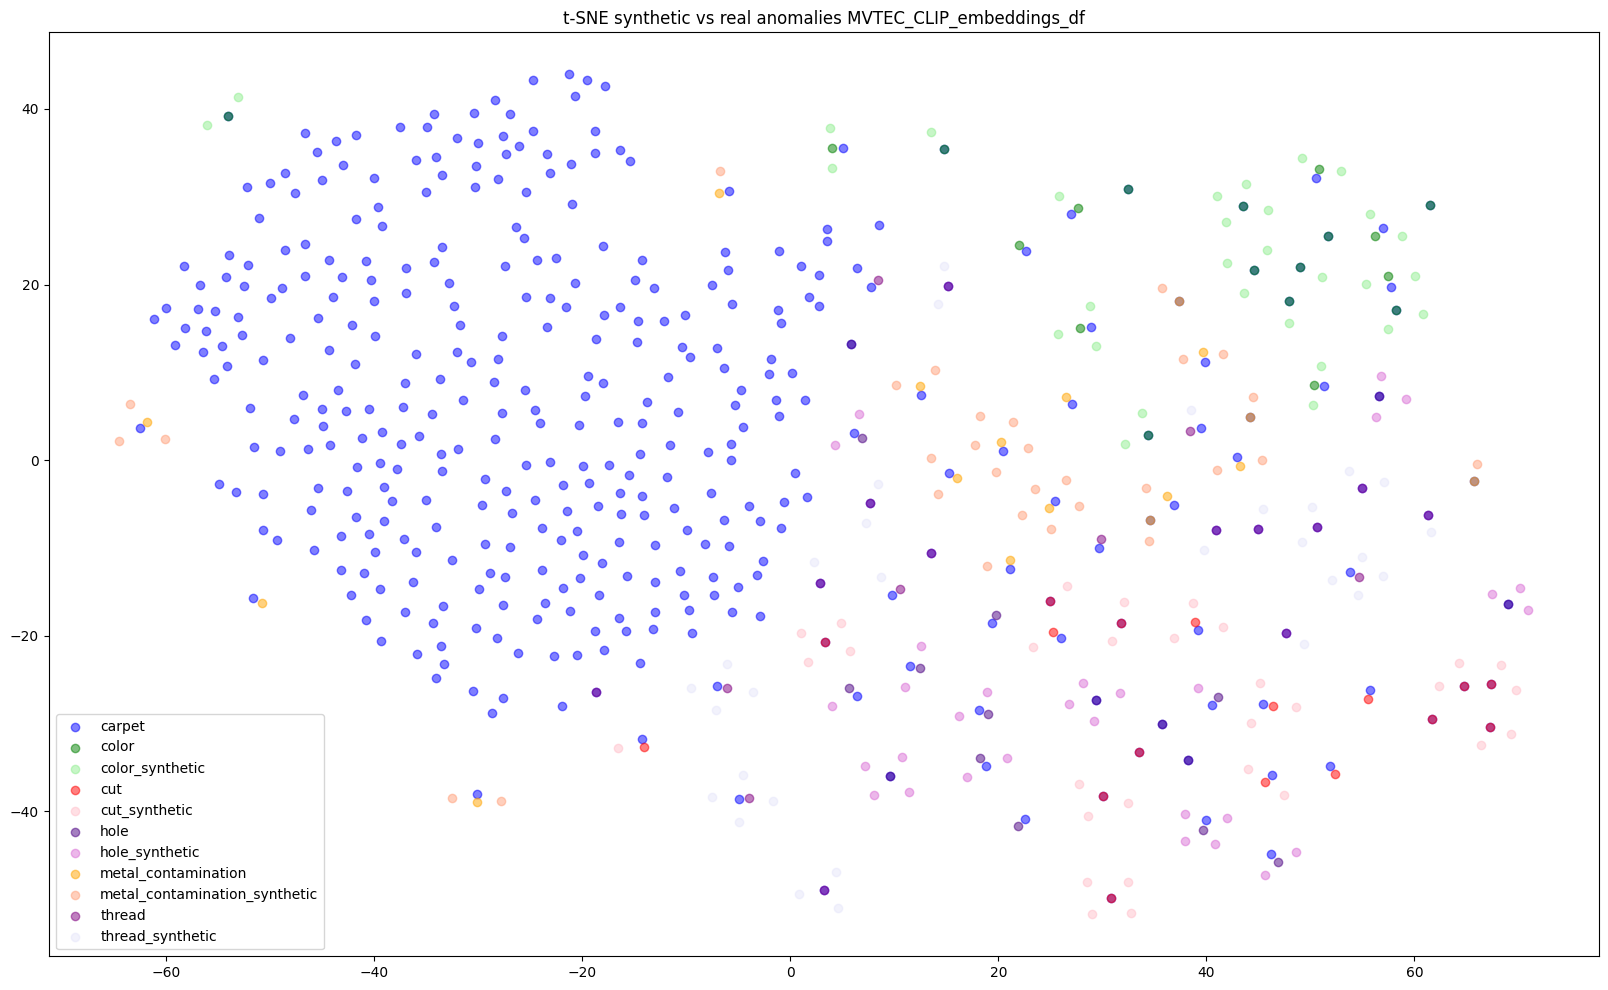

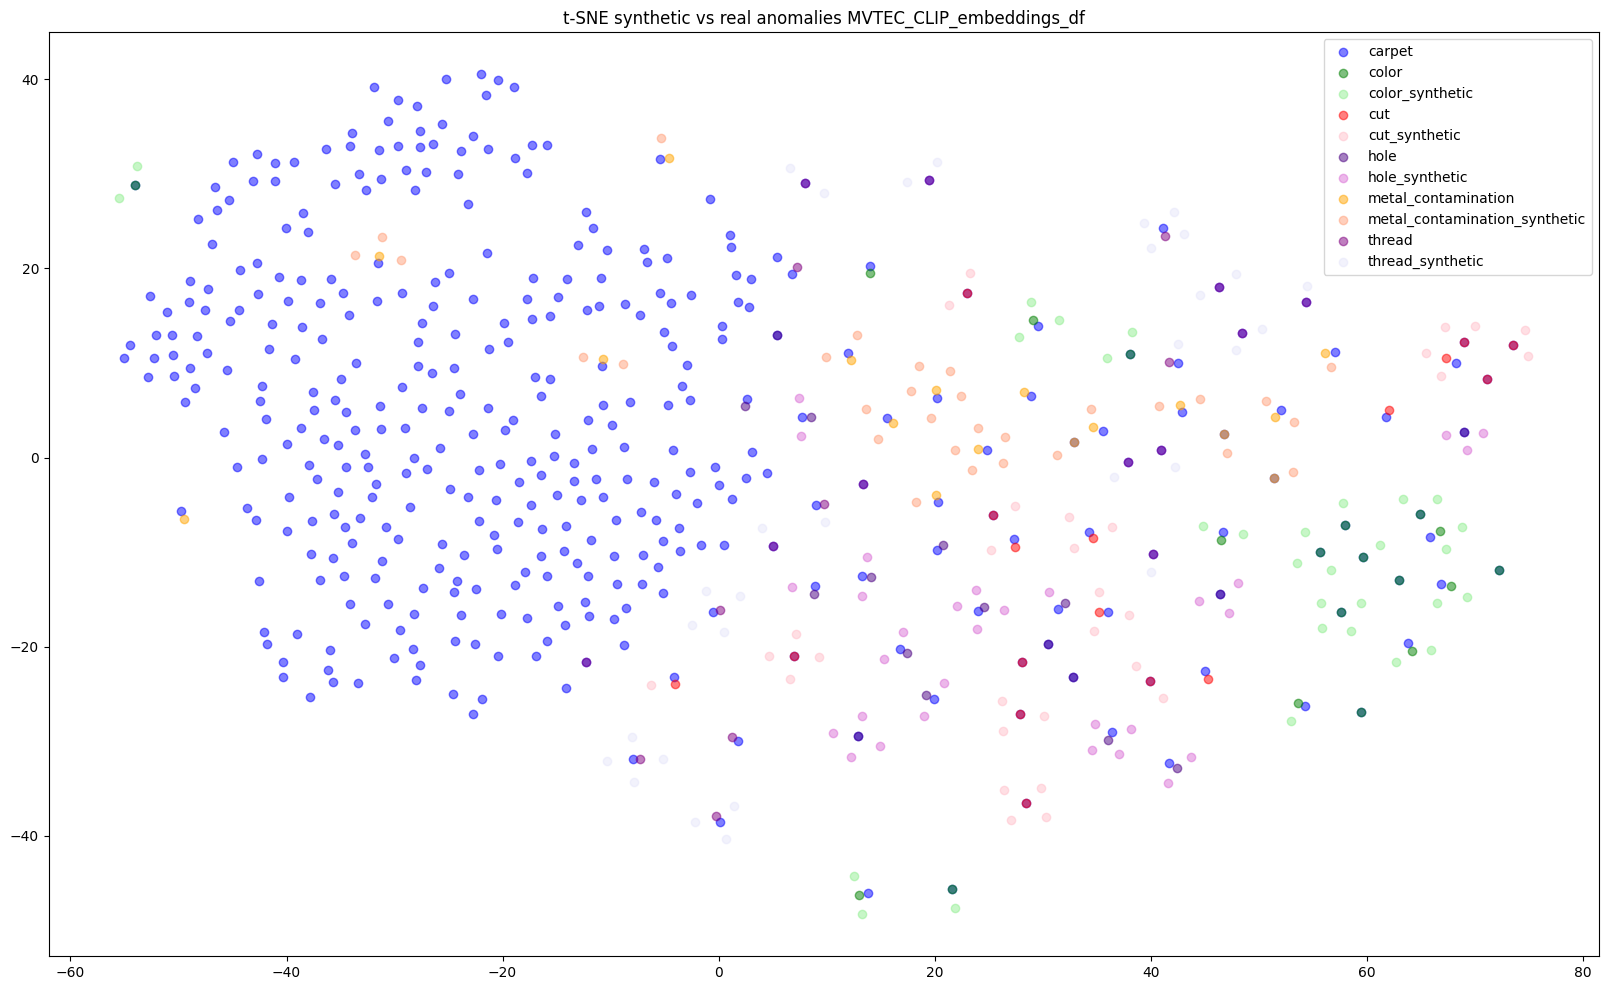

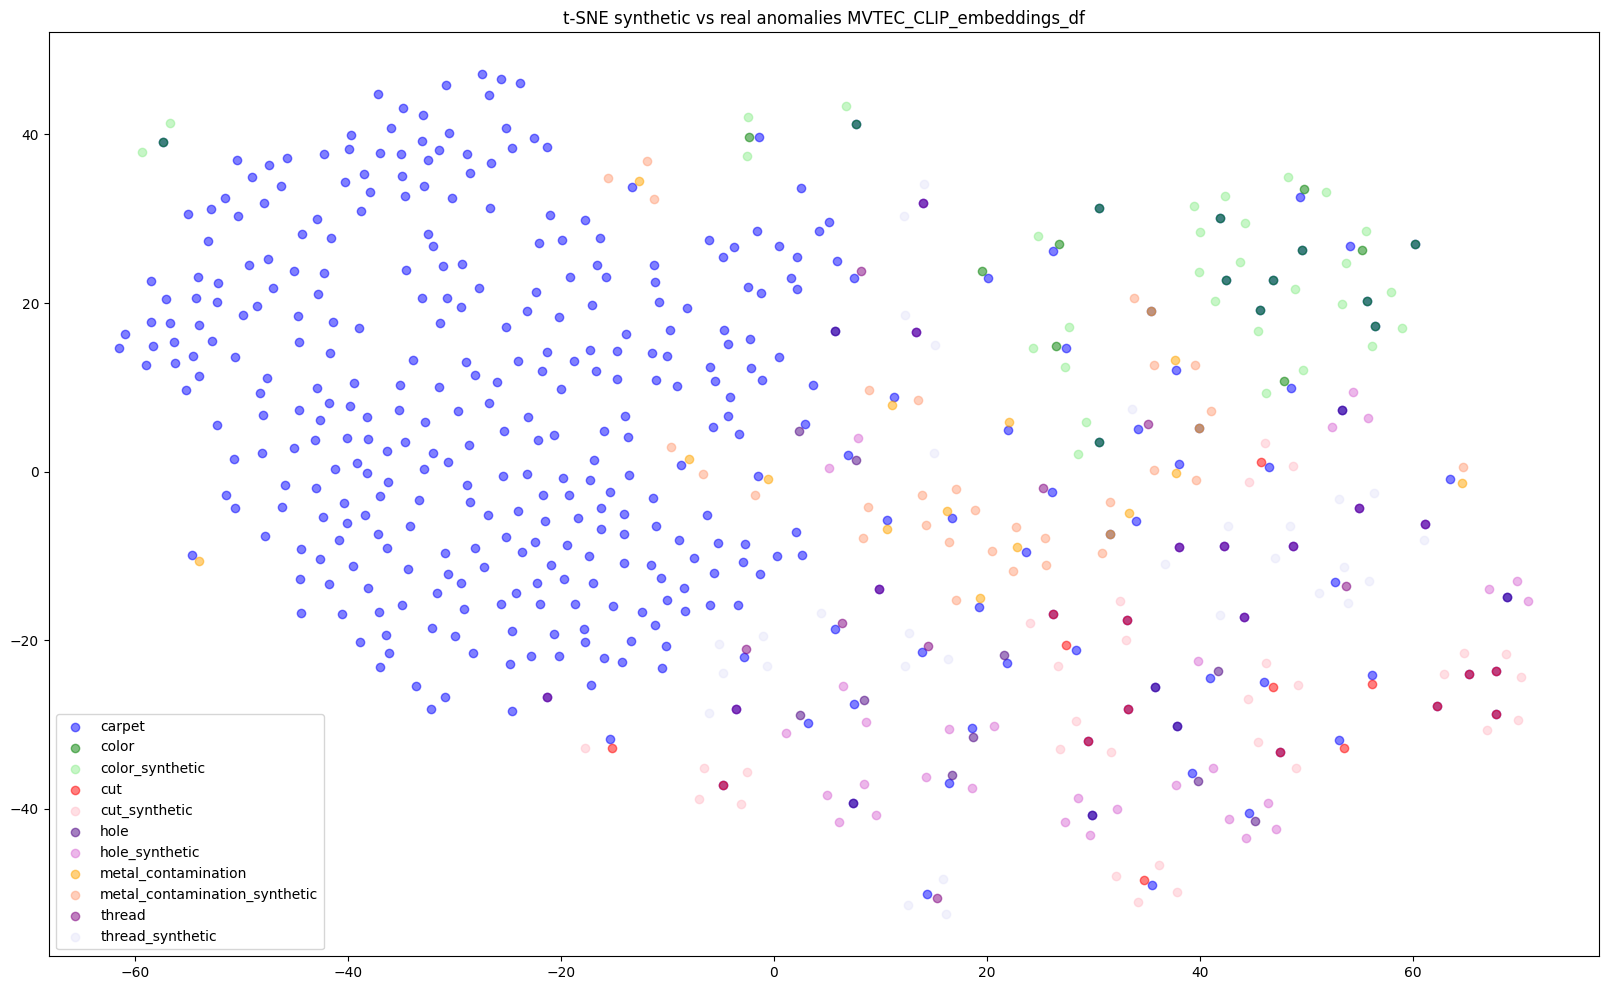

In [4]:
for _ in range(5):

    # Apply t-SNE
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000)#, random_state=0
    reduced_data = tsne.fit_transform(combined_samples)

    colors = ['blue', 'green', 'lightgreen', 'red', 'pink', 'indigo', 'orchid', 'orange', 'lightsalmon', 'purple', 'lavender', 'saddlebrown', 'wheat', 'black', 'gray','olive', 'palegreen']

    # Plotting
    plt.figure(figsize=(20, 12))
    # Iterate over each unique label to plot them separately
    for i in range(len(class_list)):
        plt.scatter(reduced_data[labels == i, 0], reduced_data[labels == i, 1], label=f'{class_list[i]}', alpha=0.5,color=colors[i])

    plt.title(f't-SNE synthetic vs real anomalies {FILENAME}')
    plt.legend()
    plt.show()



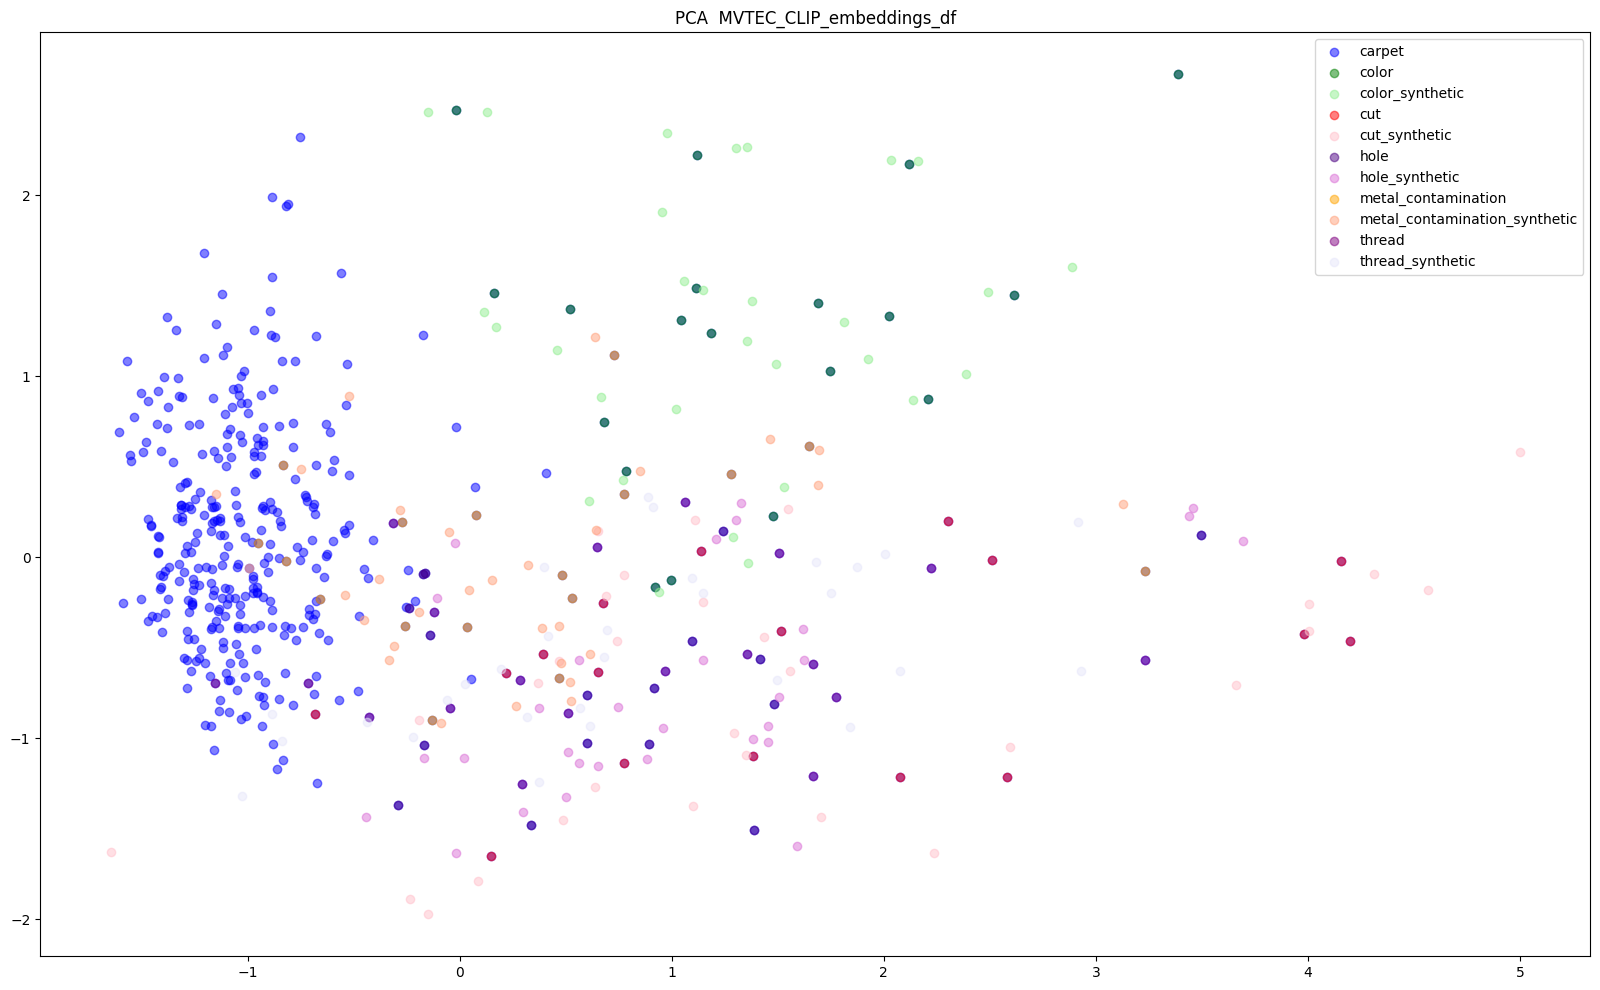

In [5]:
# Apply PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(combined_samples)

colors = ['blue', 'green', 'lightgreen', 'red', 'pink', 'indigo', 'orchid', 'orange', 'lightsalmon', 'purple', 'lavender', 'saddlebrown', 'wheat', 'black', 'gray','olive', 'palegreen']

# Plotting
plt.figure(figsize=(20, 12))
# Iterate over each unique label to plot them separately
for i in range(len(class_list)):
    plt.scatter(reduced_data[labels == i, 0], reduced_data[labels == i, 1], label=f'{class_list[i]}', alpha=0.5,color=colors[i])
plt.title(f'PCA  {FILENAME}')
plt.legend()
plt.show()

In [6]:
# filter for the synthetic and real anomalies
normals=combined_samples[labels==0]
anomalies=combined_samples[(labels % 2 != 0) & (labels != 0)] 
synthetic_anomalies=combined_samples[(labels % 2 == 0) & (labels != 0)] 
normals.shape

(397, 512)

In [7]:
normals.shape[1]

512

Epoch [1/50], Train Loss: 15.9362, Validation Loss: 0.0166
Epoch [2/50], Train Loss: 0.0092, Validation Loss: 0.0070
Epoch [3/50], Train Loss: 0.0064, Validation Loss: 0.0055
Epoch [4/50], Train Loss: 0.0057, Validation Loss: 0.0052
Epoch [5/50], Train Loss: 0.0055, Validation Loss: 0.0056
Epoch [6/50], Train Loss: 0.0056, Validation Loss: 0.0057
Epoch [7/50], Train Loss: 0.0058, Validation Loss: 0.0059
Epoch [8/50], Train Loss: 0.0058, Validation Loss: 0.0060
Epoch [9/50], Train Loss: 0.0075, Validation Loss: 0.0079
Early stopping triggered!


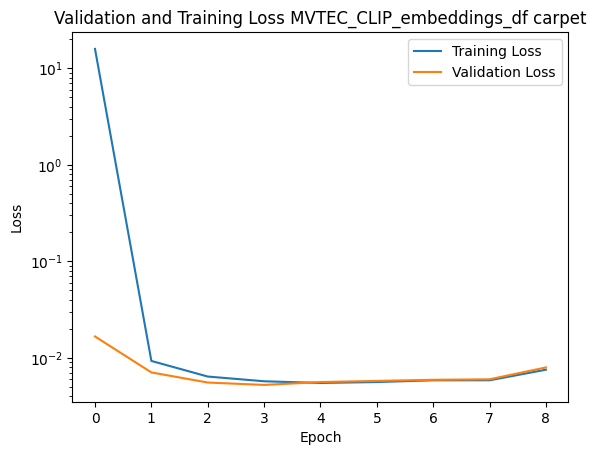

In [8]:

# Assuming 'normals' is your input data
data = torch.tensor(normals)

# Splitting data into training and validation sets
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# Creating TensorDatasets for training and validation sets
train_dataset = TensorDataset(train_data)
val_dataset = TensorDataset(val_data)

# Creating DataLoaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10)

class SimpleAutoencoder(nn.Module):
    def __init__(self,input_shape=200704):
        super(SimpleAutoencoder, self).__init__()
        # Encoder layers
        self.input_shape=input_shape
        
        self.encoder = nn.Sequential(
            nn.Linear(self.input_shape, 1000),  # Reducing dimension from 200704 to 1000
            nn.ReLU(),
            nn.Linear(1000, 500),     # Further reduction to 500
            nn.ReLU(),
            nn.Linear(500, 100)       # Code layer with 100 features
        )
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(100, 500),      # Expanding from 100 to 500
            nn.ReLU(),
            nn.Linear(500, 1000),     # Expanding from 500 to 1000
            nn.ReLU(),
            nn.Linear(1000, self.input_shape)   # Reconstructing the original 200704 features
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x



# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder = SimpleAutoencoder(input_shape=normals.shape[1]).to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.01)

num_epochs = 50
patience = 5  # Early stopping patience
best_val_loss = np.inf
epochs_no_improve = 0
train_loss_log = []
val_loss_log = []

for epoch in range(num_epochs):
    autoencoder.train()
    train_loss = 0.0

    for data in train_loader:
        inputs = data[0].to(device)
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = loss_function(outputs, inputs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss = train_loss / len(train_loader)
    train_loss_log.append(train_loss)

    autoencoder.eval()
    val_loss = 0.0

    with torch.no_grad():
        for data in val_loader:
            inputs = data[0].to(device)
            outputs = autoencoder(inputs)
            loss = loss_function(outputs, inputs)
            val_loss += loss.item()

    val_loss = val_loss / len(val_loader)
    val_loss_log.append(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

    if epochs_no_improve == patience:
        print('Early stopping triggered!')
        break

# Save the model
#torch.save(autoencoder.state_dict(), 'autoencoder.pth')

# Plotting the validation and training loss with logarithmic scale
plt.plot(train_loss_log, label='Training Loss')
plt.plot(val_loss_log, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Validation and Training Loss {FILENAME} {category}')
plt.legend()
plt.yscale('log')  # Set y-axis scale to logarithmic
plt.show()


In [9]:
# put through network ("could also use mse loss directly :D")
normalscores=F.mse_loss(autoencoder(torch.Tensor(normals).to(device)), torch.Tensor(normals).to(device))
anoscores=F.mse_loss(autoencoder(torch.Tensor(anomalies).to(device)), torch.Tensor(anomalies).to(device))
synanoscores=F.mse_loss(autoencoder(torch.Tensor(synthetic_anomalies).to(device)), torch.Tensor(synthetic_anomalies).to(device))
# Compute MSE scores
normal_scores = F.mse_loss(autoencoder(torch.Tensor(normals).to(device)), torch.Tensor(normals).to(device), reduction='none').mean(1)
anomaly_scores = F.mse_loss(autoencoder(torch.Tensor(anomalies).to(device)), torch.Tensor(anomalies).to(device), reduction='none').mean(1)
synthetic_anomaly_scores = F.mse_loss(autoencoder(torch.Tensor(synthetic_anomalies).to(device)), torch.Tensor(synthetic_anomalies).to(device), reduction='none').mean(1)
# Convert to CPU and to numpy array
normal_scores = normal_scores.cpu().detach().numpy()
anomaly_scores = anomaly_scores.cpu().detach().numpy()
synthetic_anomaly_scores = synthetic_anomaly_scores.cpu().detach().numpy()

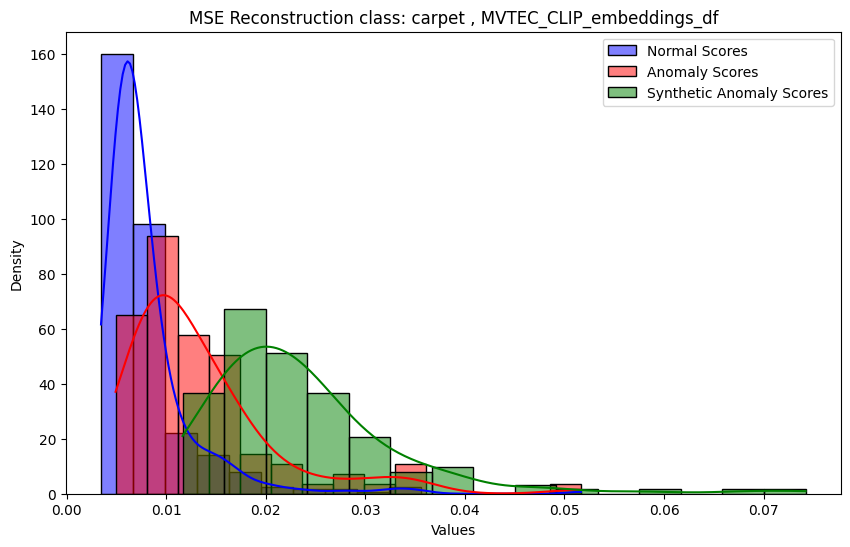

In [10]:
plt.figure(figsize=(10, 6))  

bins_number = 15  
sns.histplot(normal_scores, label='Normal Scores', kde=True, color='blue', stat="density", alpha=0.5, bins=bins_number)
sns.histplot(anomaly_scores, label='Anomaly Scores', kde=True, color='red', stat="density", alpha=0.5, bins=bins_number)
sns.histplot(synthetic_anomaly_scores, label='Synthetic Anomaly Scores', kde=True, color='green', stat="density", alpha=0.5, bins=bins_number)
plt.title(f'MSE Reconstruction class: {category} , {FILENAME}')
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend() 
plt.show()